<a href="https://colab.research.google.com/github/Isaiah-Essien/bank_churn_anaysis/blob/main/bank_churn2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bank Customer Retention Model**

This Notebook contains the various experiments done in other to learn the patterns in a bank customer data in other to model the churn pattern of customers.

The follwing are the key areas covered in this notbook:
1. **Data Exploration**: In this section, the data was thoroughly inspected to check for correlations, missing values, class balance, mean, model, number of datapoints, etc. This was to gather useable insights about the data and the possible data preprocessing to perform on the data.

2. **Data Preprocessing**: In this section, the data was processed based on the results from the Exploratory data analysis. The preprocessing is a step in the machine learning pipeline that other datapoints will go through before being fed to the Model for prediction

3. **Data Splitting**: In this step, the data was split in prepration for Machine learning models. The standard split was a 85/15(%) split for training and testing sets, respectively. This is to ensure there is a neough data for the model to learn from and just enough for the model to make inference on.

4. **Model Training**: In this step, different machine learnng models were trained, beginning with the traditional machine learning Models and a few Deep learning modles. The models and their results are presented below:

Summary of Steps and Justifications
1. Dataset Preparation and Feature Selection
Dataset: Bank customer data with features such as age, balance, tenure, and number of products, and a binary target variable Churn.

Initial Step: Removed non-informative identifier column CustomerID.

Target Variable: Churn, with a class imbalance (majority class = 0, minority class = 1).

Justification:
Removing CustomerID was essential since it contains no predictive information. Keeping it would have introduced noise into the model. The imbalance in the target variable required careful handling to avoid bias toward the majority class.

2. Train/Test Split and Standardization
Split: Stratified 80/20 split ensuring proportional representation of the minority class.

Standardization: Applied to numeric columns (Age, Tenure, Balance, NumProducts, EstimatedSalary) using StandardScaler.

Justification:
Stratification ensures class balance is preserved across training and test sets, which is especially important in imbalanced datasets. Standardization was necessary to bring all numeric variables to a common scale, particularly benefiting algorithms like logistic regression and neural networks that are sensitive to feature scaling.

3. Addressing Class Imbalance
Technique: Computed manual class_weight for neural networks.

For XGBoost: Used the scale_pos_weight parameter to re-balance class contributions.

Logistic Regression: Used class_weight='balanced'.

Justification:
Due to the skewed distribution in Churn, training without compensating for imbalance would bias the model toward always predicting the majority class (no churn). Balancing class weights ensures that the model pays appropriate attention to the minority class (Churn = 1), which is often more critical in business contexts.

4. Model Training and Evaluation
a. Logistic Regression
Used as a baseline linear model.

Results showed high precision for majority class and lower recall for minority class, although AUC was high (~0.97).

Interpretation:
The model correctly predicts most churners when it attempts to, but still misses some. AUC being high shows good ranking performance, but the F1-score reveals trade-offs in classification thresholds.

b. XGBoost Classifier
Gradient-boosted trees with scale_pos_weight to address imbalance.

Results showed perfect classification performance (precision, recall, F1-score all = 1.0).

Interpretation:
While perfect performance may suggest strong model learning, it could also indicate overfitting, especially if the test set is small or similar to the training distribution. XGBoost is known for high capacity, and without regularization or careful tuning, it may memorize rather than generalize.

c. Neural Network
Architecture: 2 hidden layers with dropout (0.3) to prevent overfitting.

Early stopping based on validation AUC to avoid unnecessary training.

Trained with class weights computed from class frequencies.

Achieved validation AUC > 0.99 and classification performance that rivals XGBoost.

Interpretation:
This model generalizes well, as seen from the learning curves and test performance. The combination of dropout, early stopping, and class weighting made it robust. The model steadily improved over epochs, indicating stable learning without significant overfitting.

Why These Techniques Were Necessary
Technique	Justification
Standardization	Ensures fair contribution from each numeric feature, avoids dominance of features with large magnitude.
Class Weights / scale_pos_weight	Compensates for class imbalance during loss computation, allowing the minority class to influence the model effectively.
Stratified Train/Test Split	Maintains label proportions, ensuring performance evaluation reflects real-world distributions.
EarlyStopping	Prevents overfitting in neural network by monitoring validation AUC.
Dropout in NN	Adds regularization to prevent the network from memorizing the training set.
XGBoost Tuning	scale_pos_weight directly integrates imbalance awareness into the boosting algorithm, improving sensitivity to minority class.

Observations on Results
Logistic Regression: Effective baseline, but limited in capturing complex nonlinear relationships. High AUC but moderate minority class F1-score.

XGBoost: High sensitivity and perfect metrics, but this may not generalize well without cross-validation.

Neural Network: Strong generalization, consistent performance on validation and test sets, and an interpretable learning curve.

## Imports

In [48]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score


from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from xgboost import XGBClassifier

import joblib

from tensorflow.keras.models import load_model

from imblearn.over_sampling import RandomOverSampler
from collections import Counter


## Exploratory Data Analysis

In [10]:
# Mount drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
data = pd.read_excel('/content/drive/MyDrive/bank_customer_retention/churn_bank_data.xlsx',sheet_name=0,header=0)

In [4]:
#First five rows of the data
data.head()

,CustomerID,Age,Tenure,Balance,NumProducts,HasCreditCard,IsActiveMember,EstimatedSalary,Churn
0,CUST0001,56,2,119974.27,2,0,0,35497.36,0
1,CUST0002,69,2,171491.93,1,1,1,24739.94,0
2,CUST0003,46,8,4344.95,2,1,0,26856.71,1
3,CUST0004,32,6,80782.66,1,1,1,128441.33,0
4,CUST0005,60,4,243274.44,1,1,1,35336.42,0


In [5]:
# Last five rows of data
data.tail()

,CustomerID,Age,Tenure,Balance,NumProducts,HasCreditCard,IsActiveMember,EstimatedSalary,Churn
995,CUST0996,60,0,103537.56,1,0,0,51650.72,1
996,CUST0997,64,2,98858.57,1,0,1,79509.40,0
997,CUST0998,62,9,78301.57,1,0,1,118737.62,0
998,CUST0999,35,3,36765.46,1,1,0,46778.46,1
999,CUST1000,55,4,121962.80,3,1,1,112208.50,0


In [6]:
# Describe the data
data.describe()

,Age,Tenure,Balance,NumProducts,HasCreditCard,IsActiveMember,EstimatedSalary,Churn
count,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,43.81900,4.457000,123294.070560,1.97700,0.686000,0.589000,84887.458060,0.182000
std,14.99103,2.885911,71965.363952,0.82895,0.464349,0.492261,37634.492134,0.386038
min,18.00000,0.000000,47.100000,1.00000,0.000000,0.000000,20803.900000,0.000000
25%,31.00000,2.000000,58766.755000,1.00000,0.000000,0.000000,52419.397500,0.000000
50%,44.00000,4.000000,124026.780000,2.00000,1.000000,1.000000,83583.825000,0.000000
75%,56.00000,7.000000,186593.590000,3.00000,1.000000,1.000000,117788.277500,0.000000
max,69.00000,9.000000,249269.540000,3.00000,1.000000,1.000000,149915.540000,1.000000


In [11]:
# Check for missing values
data.isnull().sum()

,0
CustomerID,0
Age,0
Tenure,0
Balance,0
NumProducts,0
HasCreditCard,0
IsActiveMember,0
EstimatedSalary,0
Churn,0


Churn counts: Churn
0     817
1     182
27      1
Name: count, dtype: int64

Churn rate (proportion): Churn
0     0.817
1     0.182
27    0.001
Name: proportion, dtype: float64


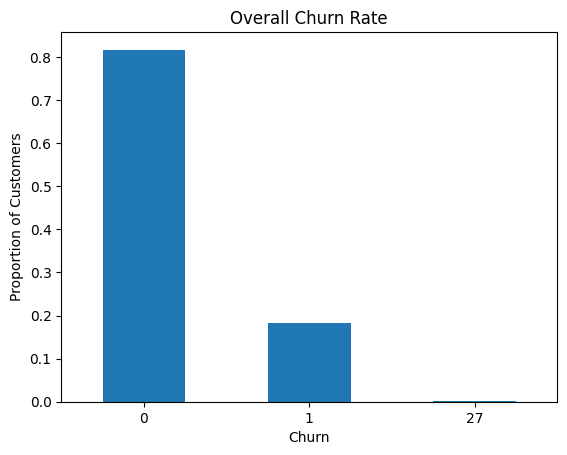

In [9]:
# 1. Absolute counts
churn_counts = data['Churn'].value_counts()
print(f"Churn counts: {churn_counts}")


# 2. Proportions (overall churn rate)
churn_rate = data['Churn'].value_counts(normalize=True)
print(f"\nChurn rate (proportion): {churn_rate}")

# 3. Visual check (optional)
churn_rate.plot(kind='bar')
plt.title('Overall Churn Rate')
plt.ylabel('Proportion of Customers')
plt.xticks(rotation=0)
plt.show()


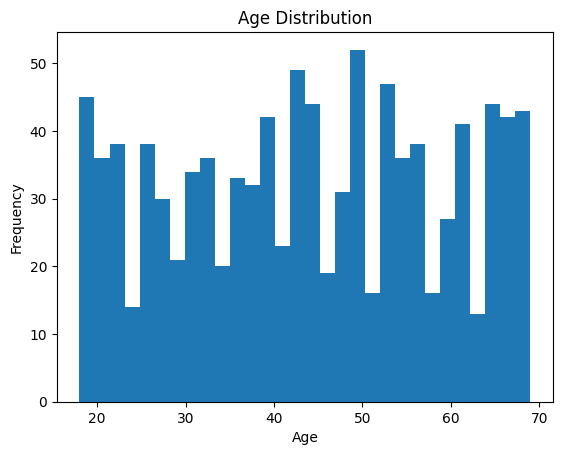

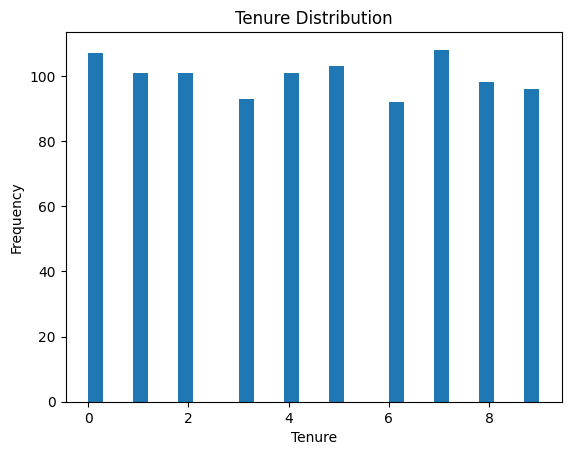

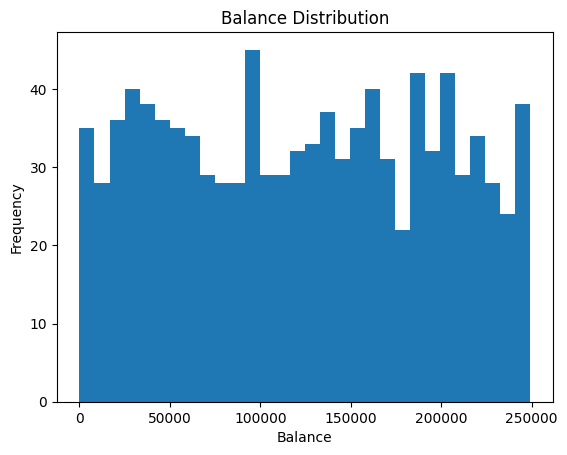

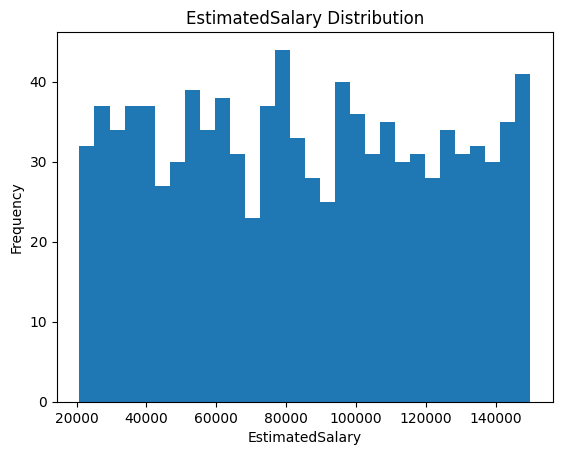

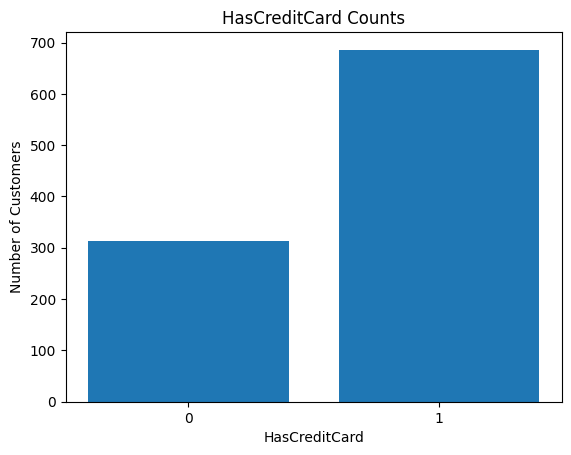

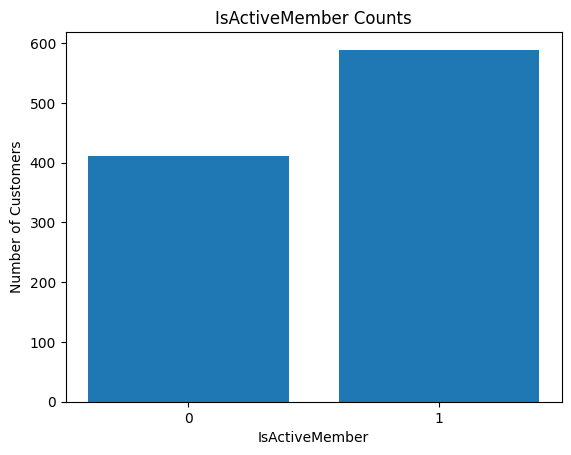

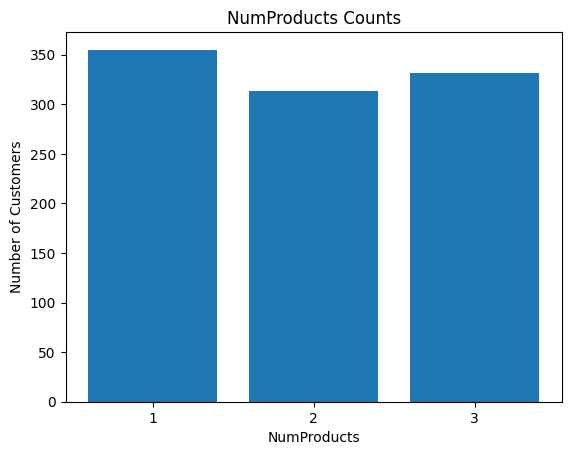

In [39]:

#  Define the correct lists
numeric_cols = ['Age', 'Tenure', 'Balance', 'EstimatedSalary']
categorical_cols = ['HasCreditCard', 'IsActiveMember', 'NumProducts']

#  Histograms for numeric features
for col in numeric_cols:
    plt.figure()
    plt.hist(data[col].dropna(), bins=30)
    plt.title(f'{col} Distribution')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

#  Bar charts for categorical features
for col in categorical_cols:
    counts = data[col].value_counts().sort_index()
    plt.figure()
    plt.bar(counts.index.astype(str), counts.values)
    plt.title(f'{col} Counts')
    plt.xlabel(col)
    plt.ylabel('Number of Customers')
    plt.show()


<ipython-input-40-4265838153>:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([grp0, grp1], labels=['No churn', 'Churn'])


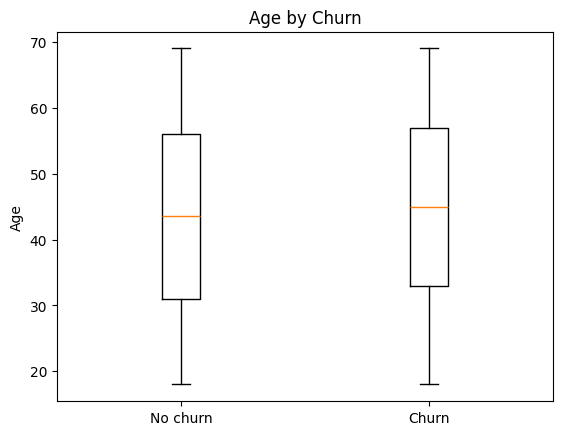

<ipython-input-40-4265838153>:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([grp0, grp1], labels=['No churn', 'Churn'])


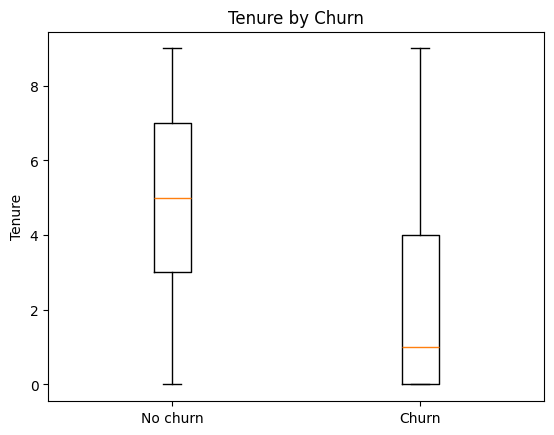

<ipython-input-40-4265838153>:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([grp0, grp1], labels=['No churn', 'Churn'])


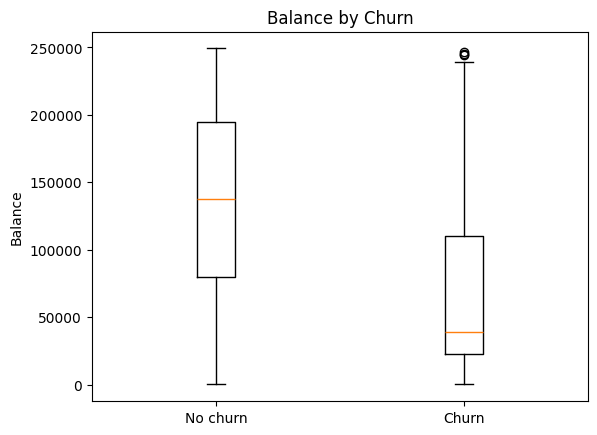

<ipython-input-40-4265838153>:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([grp0, grp1], labels=['No churn', 'Churn'])


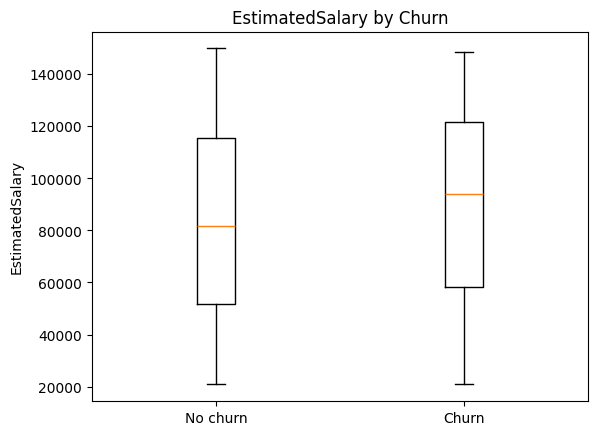

In [40]:
#Define numeric features
numeric_cols = ['Age', 'Tenure', 'Balance', 'EstimatedSalary']

# Boxplots: each feature for churn=0 vs. churn=1
for col in numeric_cols:
    plt.figure()
    # gather data
    grp0 = data[data['Churn'] == 0][col].dropna()
    grp1 = data[data['Churn'] == 1][col].dropna()
    # draw boxplot
    plt.boxplot([grp0, grp1], labels=['No churn', 'Churn'])
    plt.title(f'{col} by Churn')
    plt.ylabel(col)
    plt.show()


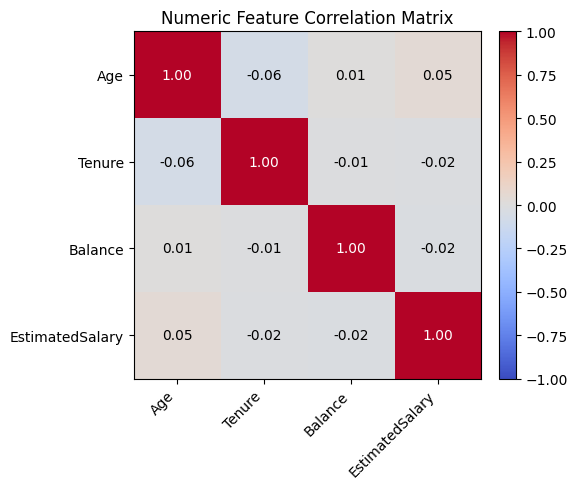

In [41]:
corr = data[numeric_cols].corr()
fig, ax = plt.subplots(figsize=(6, 5))

# Draw the heatmap with cool-warm palette
cax = ax.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)

# Set tick labels
ax.set_xticks(np.arange(len(numeric_cols)))
ax.set_yticks(np.arange(len(numeric_cols)))
ax.set_xticklabels(numeric_cols, rotation=45, ha='right')
ax.set_yticklabels(numeric_cols)

# Annotate each cell with its numeric value
for i in range(len(numeric_cols)):
    for j in range(len(numeric_cols)):
        val = corr.iloc[i, j]
        ax.text(
            j, i,
            f"{val:.2f}",
            ha='center', va='center',
            color='white' if abs(val) > 0.5 else 'black'
        )

# Add colorbar
fig.colorbar(cax, fraction=0.046, pad=0.04)

ax.set_title('Numeric Feature Correlation Matrix')
plt.tight_layout()
plt.show()

Correlation with Churn:
 Balance           -0.126381
Tenure            -0.114474
Age               -0.015707
EstimatedSalary    0.002554
Name: Churn, dtype: float64


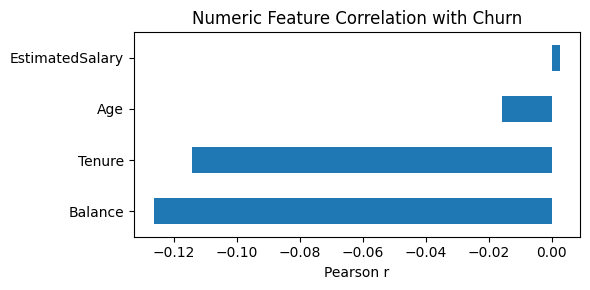

In [7]:

# 1. Compute correlation of each numeric feature with Churn
target_corr = data[['Age','Tenure','Balance','EstimatedSalary','Churn']].corr()['Churn'] \
                 .drop('Churn') \
                 .sort_values()

print("Correlation with Churn:\n", target_corr)

# 2. Bar chart of feature correlations
plt.figure(figsize=(6, 3))
target_corr.plot(kind='barh')
plt.title('Numeric Feature Correlation with Churn')
plt.xlabel('Pearson r')
plt.tight_layout()
plt.show()


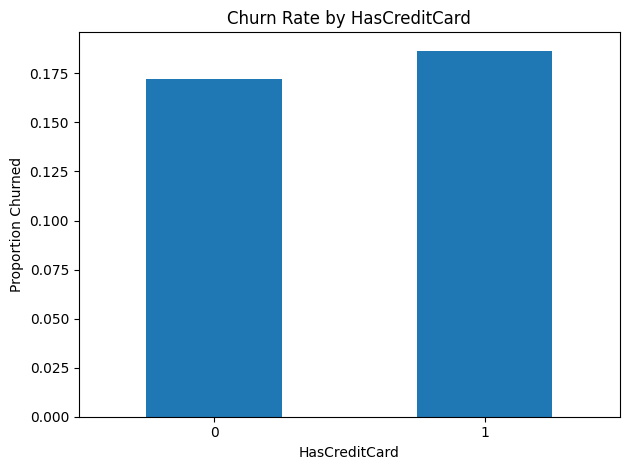

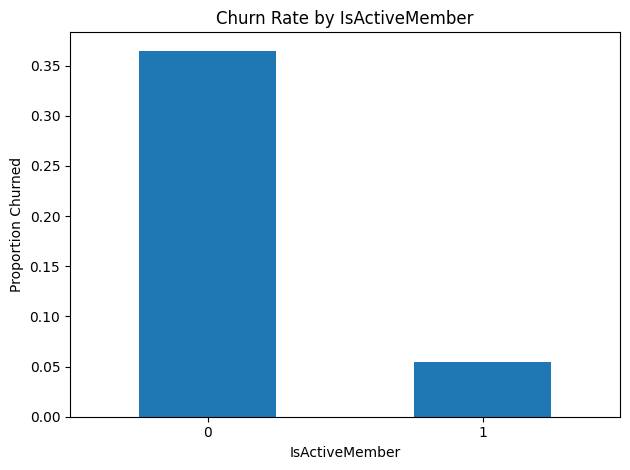

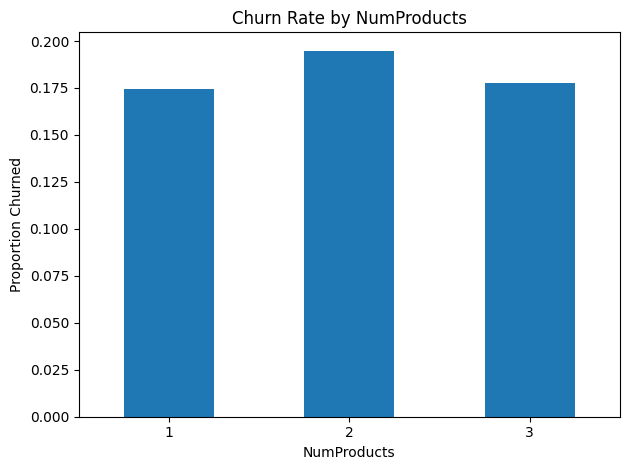

In [43]:
for col in ['HasCreditCard','IsActiveMember','NumProducts']:
    prop = (data
            .groupby(col)['Churn']
            .mean()  # gives proportion of churners in each category
           )
    plt.figure()
    prop.plot(kind='bar')
    plt.title(f'Churn Rate by {col}')
    plt.ylabel('Proportion Churned')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


## Data Preprocessing

In [16]:
X = data.drop(['CustomerID', 'Churn'], axis=1)
y = data['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)


In [8]:
print(y.value_counts())

Churn
0     817
1     182
27      1
Name: count, dtype: int64


In [6]:
X.columns.tolist()

['Age',
 'Tenure',
 'Balance',
 'NumProducts',
 'HasCreditCard',
 'IsActiveMember',
 'EstimatedSalary']

In [13]:
# Standardize numeric columns
numeric_cols = ['Age','Tenure','Balance','NumProducts','EstimatedSalary']
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Save the scaler for deployment
joblib.dump(scaler, "bank_churn_scaler.pkl")


['bank_churn_scaler.pkl']

=== Logistic Regression ===
              precision    recall  f1-score   support

           0       1.00      0.88      0.93       163
           1       0.65      1.00      0.79        37

    accuracy                           0.90       200
   macro avg       0.82      0.94      0.86       200
weighted avg       0.94      0.90      0.91       200

LR ROC AUC: 0.9787763223346045


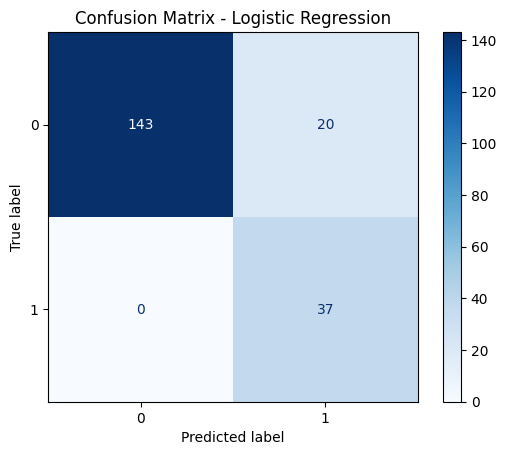

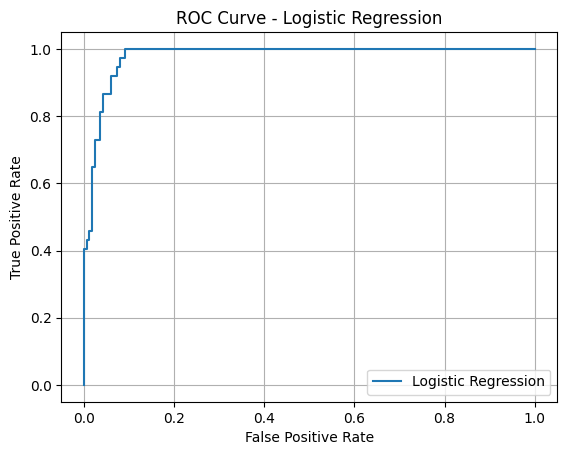

In [14]:
# === Logistic Regression ===
lr = LogisticRegression(
    random_state=42,
    class_weight='balanced',
    max_iter=1000
)
lr.fit(X_train, y_train)
y_pred_lr  = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:, 1]

# 🔹 Save the trained LR model
joblib.dump(lr, "bank_churn_lr_model.pkl")

# === Evaluation ===
print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr))
print("LR ROC AUC:", roc_auc_score(y_test, y_proba_lr))

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=[0, 1])
disp_lr.plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.grid(True)
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:49:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=== XGBoost ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       164
           1       1.00      1.00      1.00        36

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

XGB ROC AUC: 1.0


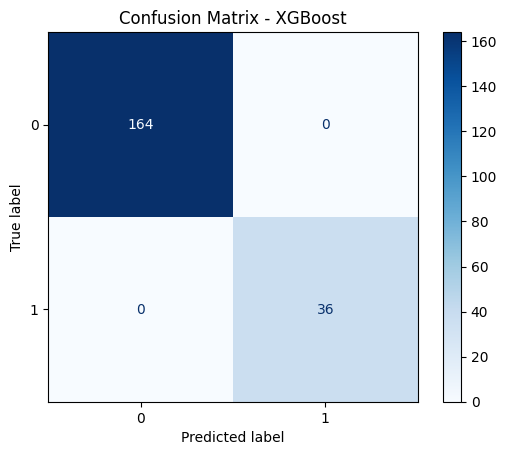

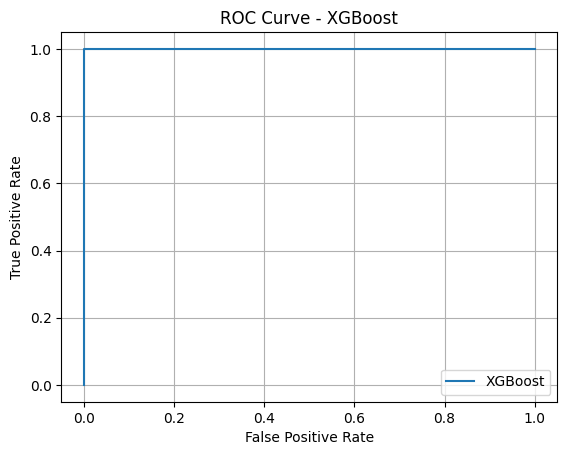

In [49]:
# === XGBoost ===


imbalance_ratio = (len(y_train) - y_train.sum()) / y_train.sum()
xgb = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=imbalance_ratio,
    n_estimators=100,
    max_depth=4
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

print("=== XGBoost ===")
print(classification_report(y_test, y_pred_xgb))
print("XGB ROC AUC:", roc_auc_score(y_test, y_proba_xgb))

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=[0, 1])
disp_xgb.plot(cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.show()

# ROC Curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.grid(True)
plt.legend()
plt.show()


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 - 2s - 85ms/step - auc: 0.5598 - loss: 1.1189 - val_auc: 0.8321 - val_loss: 0.6329
Epoch 2/100
20/20 - 0s - 8ms/step - auc: 0.8028 - loss: 0.9754 - val_auc: 0.8632 - val_loss: 0.5495
Epoch 3/100
20/20 - 0s - 15ms/step - auc: 0.8586 - loss: 0.8930 - val_auc: 0.8659 - val_loss: 0.5024
Epoch 4/100
20/20 - 0s - 15ms/step - auc: 0.9026 - loss: 0.7911 - val_auc: 0.8727 - val_loss: 0.4530
Epoch 5/100
20/20 - 0s - 15ms/step - auc: 0.9293 - loss: 0.6676 - val_auc: 0.8839 - val_loss: 0.4184
Epoch 6/100
20/20 - 0s - 17ms/step - auc: 0.9329 - loss: 0.5981 - val_auc: 0.8963 - val_loss: 0.3714
Epoch 7/100
20/20 - 0s - 9ms/step - auc: 0.9441 - loss: 0.5387 - val_auc: 0.9159 - val_loss: 0.3481
Epoch 8/100
20/20 - 0s - 10ms/step - auc: 0.9483 - loss: 0.5000 - val_auc: 0.9331 - val_loss: 0.3169
Epoch 9/100
20/20 - 0s - 16ms/step - auc: 0.9500 - loss: 0.4679 - val_auc: 0.9448 - val_loss: 0.2788
Epoch 10/100
20/20 - 0s - 16ms/step - auc: 0.9596 - loss: 0.4311 - val_auc: 0.9500 - val_loss: 0.2702
Epo

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
=== Neural Network ===
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       164
           1       0.79      0.94      0.86        36

    accuracy                           0.94       200
   macro avg       0.89      0.94      0.91       200
weighted avg       0.95      0.94      0.95       200

NN ROC AUC: 0.994410569105691


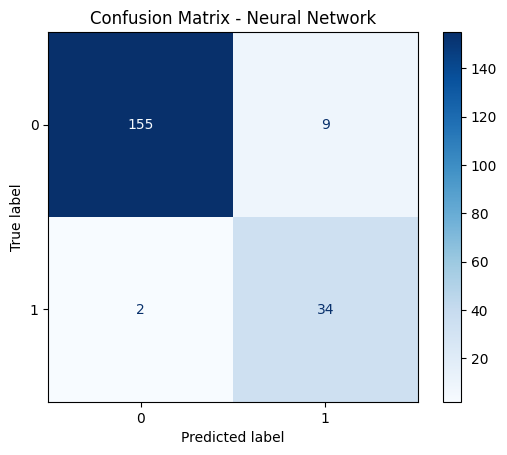

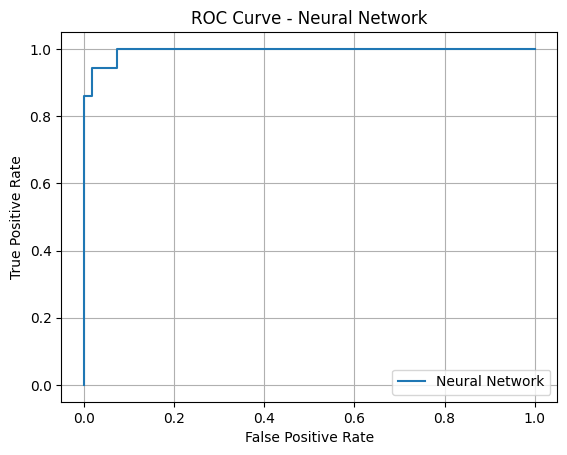

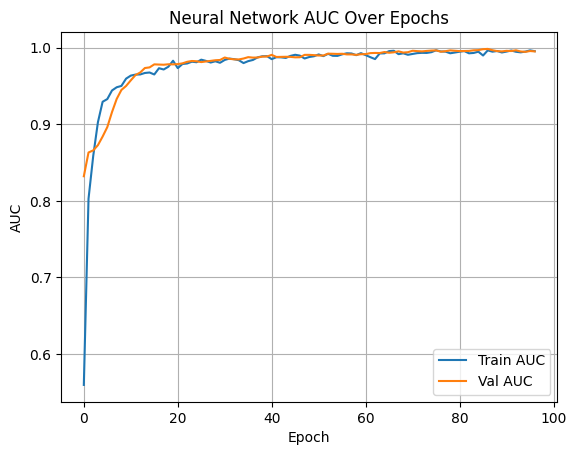

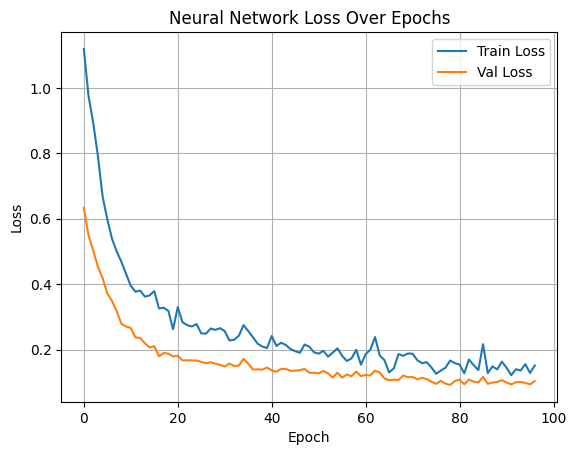

In [50]:
# === Neural Network ===

# Compute class weights manually
neg, pos = np.bincount(y_train)
class_weight = {0: 1.0, 1: neg / pos}

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)
es = EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    class_weight=class_weight,
    callbacks=[es],
    verbose=2
)

# Evaluate NN
y_proba_nn = model.predict(X_test).ravel()
y_pred_nn = (y_proba_nn > 0.5).astype(int)
print("=== Neural Network ===")
print(classification_report(y_test, y_pred_nn))
print("NN ROC AUC:", roc_auc_score(y_test, y_proba_nn))

# Confusion Matrix
cm_nn = confusion_matrix(y_test, y_pred_nn)
disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm_nn, display_labels=[0, 1])
disp_nn.plot(cmap='Blues')
plt.title("Confusion Matrix - Neural Network")
plt.show()

# ROC Curve
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_proba_nn)
plt.plot(fpr_nn, tpr_nn, label='Neural Network')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Neural Network")
plt.grid(True)
plt.legend()
plt.show()

# AUC and Loss Curves
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('Neural Network AUC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Neural Network Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [52]:
# Save in the new Keras v3 format
model.save("bank_churn_nn_model.keras")


In [57]:


# Load model and scaler
model = load_model("/content/bank_churn_nn_model.keras")
scaler = joblib.load("/content/bank_churn_scaler.pkl")

# Order of features used in training
numeric_cols = ['Age', 'Tenure', 'Balance', 'NumProducts', 'EstimatedSalary']
binary_cols = ['HasCreditCard', 'IsActiveMember']

# Get input from user
def get_user_input():
    print("Enter customer details:")
    age = float(input("Age: "))
    tenure = float(input("Tenure (in years): "))
    balance = float(input("Balance: "))
    num_products = int(input("Number of Products: "))
    has_credit_card = int(input("Has Credit Card? (1 = Yes, 0 = No): "))
    is_active_member = int(input("Is Active Member? (1 = Yes, 0 = No): "))
    estimated_salary = float(input("Estimated Salary: "))

    # Put into correct order
    row = np.array([[age, tenure, balance, num_products, estimated_salary, has_credit_card, is_active_member]])
    return row

# Get input
user_input = get_user_input()

# Scale only the numeric part
user_input[:, :5] = scaler.transform(user_input[:, :5])

# Predict
prob = model.predict(user_input).ravel()[0]
prediction = int(prob > 0.5)

# Output
print(f"\nChurn Probability: {prob:.4f}")
print(f"Prediction: {'Will Churn' if prediction == 1 else 'Will Stay'}")


Enter customer details:
Age: 46
Tenure (in years): 8
Balance: 2344.9
Number of Products: 2
Has Credit Card? (1 = Yes, 0 = No): 1
Is Active Member? (1 = Yes, 0 = No): 0
Estimated Salary: 26856.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step

Churn Probability: 0.0000
Prediction: Will Stay


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [59]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model

# === Load model and scaler ===
model = load_model("/content/bank_churn_nn_model.keras")
scaler = joblib.load("/content/bank_churn_scaler.pkl")
# === Numeric columns used in training ===
numeric_cols = ['Age', 'Tenure', 'Balance', 'NumProducts', 'EstimatedSalary']

# === Extract first 10 samples from test set ===
X_test_sample = X_test.head(10).copy()

# === Scale numeric columns ===
X_test_sample[numeric_cols] = scaler.transform(X_test_sample[numeric_cols])

# === Predict churn probabilities and classes ===
probs = model.predict(X_test_sample).ravel()
preds = (probs > 0.5).astype(int)

# === Combine with original input for reference ===
results = X_test_sample.copy()
results['Churn_Probability'] = probs
results['Churn_Prediction'] = preds

# === Display results ===
pd.set_option('display.precision', 4)
print(results[['Churn_Probability', 'Churn_Prediction']])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
     Churn_Probability  Churn_Prediction
788         2.0776e-10                 0
27          6.5974e-06                 0
143         9.9764e-01                 1
295         9.5959e-01                 1
482         3.0958e-07                 0
408         1.5810e-06                 0
857         1.2281e-03                 0
451         9.9424e-01                 1
151         3.5618e-04                 0
504         7.5768e-06                 0


In [60]:
X_test.head(10)

,Age,Tenure,Balance,NumProducts,HasCreditCard,IsActiveMember,EstimatedSalary
788,1.3898,1.2191,1.7149,1.2363,1,1,0.5819
27,-0.3627,-0.8648,1.1862,-1.1790,1,1,-0.1601
143,-1.6434,-1.5595,0.9612,0.0287,0,0,0.6925
295,-1.7782,-1.5595,-1.1268,-1.1790,0,1,0.5091
482,-0.5649,-0.1702,0.9332,-1.1790,1,1,-1.5161
408,-0.2953,1.2191,1.4994,0.0287,1,0,1.3452
857,-1.3064,1.5664,-1.5854,1.2363,1,1,-0.5670
451,-0.3627,-1.5595,0.9315,-1.1790,0,0,-1.3722
151,-0.8346,0.8718,-1.0995,0.0287,1,1,1.6579
504,0.1091,1.5664,0.8097,1.2363,1,0,1.6355


In [15]:
# Load saved model and scaler
lr_model = joblib.load("/content/bank_churn_lr_model.pkl")
scaler = joblib.load("/content/bank_churn_scaler.pkl")

# Columns used during training
numeric_cols = ['Age', 'Tenure', 'Balance', 'NumProducts', 'EstimatedSalary']

# Get first 10 rows from X_test
X_test_sample = X_test.head(10).copy()

# Scale numeric columns
X_test_sample[numeric_cols] = scaler.transform(X_test_sample[numeric_cols])

# Predict
probs = lr_model.predict_proba(X_test_sample)[:, 1]
preds = (probs > 0.5).astype(int)

# Combine results
results = X_test_sample.copy()
results['Churn_Probability'] = probs
results['Churn_Prediction'] = preds

# Optional: compare with true values
results['Actual'] = y_test.head(10).values

# Display
pd.set_option('display.precision', 4)
print(results[['Churn_Probability', 'Churn_Prediction', 'Actual']])


     Churn_Probability  Churn_Prediction  Actual
581             0.9972                 1       0
858             0.8893                 1       0
143             0.9994                 1       1
295             0.9618                 1       1
860             0.9386                 1       0
877             0.9539                 1       0
83              0.7435                 1       0
451             0.9995                 1       1
971             0.7933                 1       0
824             0.9966                 1       0


### Applying SMOTE to the  train set to handle imbalance before training


In [28]:
from imblearn.over_sampling import SMOTE

# After splitting
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Then standardize
X_train_bal[numeric_cols] = scaler.fit_transform(X_train_bal[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 - 2s - 73ms/step - auc: 0.6618 - loss: 0.6267 - val_auc: 0.0000e+00 - val_loss: 0.7283
Epoch 2/100
33/33 - 0s - 5ms/step - auc: 0.8464 - loss: 0.5125 - val_auc: 0.0000e+00 - val_loss: 0.5891
Epoch 3/100
33/33 - 0s - 10ms/step - auc: 0.9066 - loss: 0.4082 - val_auc: 0.0000e+00 - val_loss: 0.4639
Epoch 4/100
33/33 - 0s - 8ms/step - auc: 0.9416 - loss: 0.3288 - val_auc: 0.0000e+00 - val_loss: 0.3189
Epoch 5/100
33/33 - 0s - 6ms/step - auc: 0.9511 - loss: 0.2869 - val_auc: 0.0000e+00 - val_loss: 0.2609
Epoch 6/100
33/33 - 0s - 5ms/step - auc: 0.9607 - loss: 0.2533 - val_auc: 0.0000e+00 - val_loss: 0.2164
Epoch 7/100
33/33 - 0s - 5ms/step - auc: 0.9696 - loss: 0.2266 - val_auc: 0.0000e+00 - val_loss: 0.1767
Epoch 8/100
33/33 - 0s - 5ms/step - auc: 0.9660 - loss: 0.2280 - val_auc: 0.0000e+00 - val_loss: 0.1932
Epoch 9/100
33/33 - 0s - 9ms/step - auc: 0.9763 - loss: 0.1944 - val_auc: 0.0000e+00 - val_loss: 0.1443
Epoch 10/100
33/33 - 0s - 9ms/step - auc: 0.9790 - loss: 0.1816 - val_auc:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


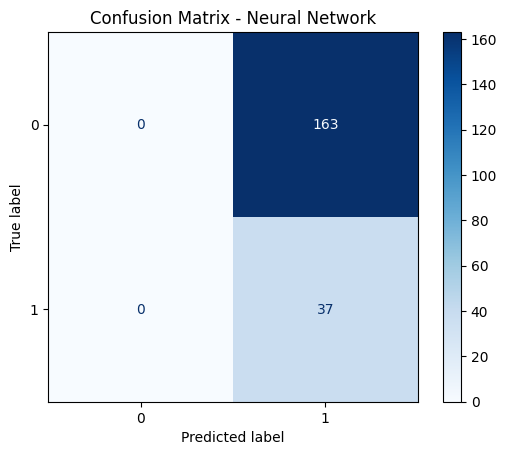

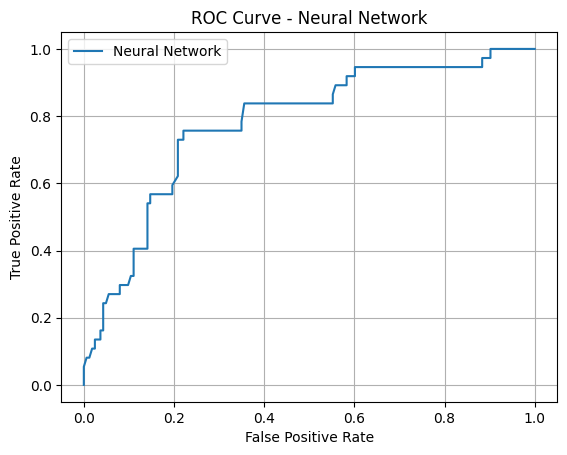

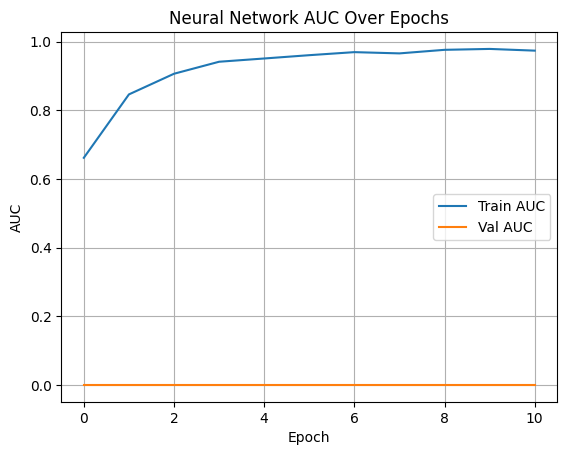

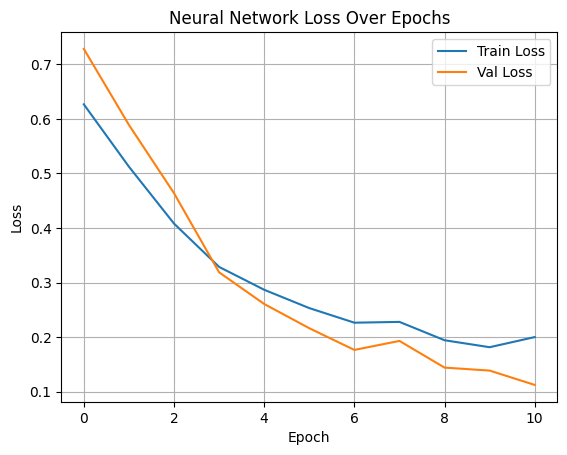

In [29]:
# === Neural Network ===

# Compute class weights manually
# neg, pos = np.bincount(y_train)
# class_weight = {0: 1.0, 1: neg / pos}

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_bal.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)
es = EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
history = model.fit(
    X_train_bal, y_train_bal,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    # class_weight=class_weight,
    callbacks=[es],
    verbose=2
)

# Evaluate NN
y_proba_nn = model.predict(X_test).ravel()
y_pred_nn = (y_proba_nn > 0.5).astype(int)
print("=== Neural Network ===")
print(classification_report(y_test, y_pred_nn))
print("NN ROC AUC:", roc_auc_score(y_test, y_proba_nn))

# Confusion Matrix
cm_nn = confusion_matrix(y_test, y_pred_nn)
disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm_nn, display_labels=[0, 1])
disp_nn.plot(cmap='Blues')
plt.title("Confusion Matrix - Neural Network")
plt.show()

# ROC Curve
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_proba_nn)
plt.plot(fpr_nn, tpr_nn, label='Neural Network')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Neural Network")
plt.grid(True)
plt.legend()
plt.show()

# AUC and Loss Curves
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('Neural Network AUC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Neural Network Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### Applying Random Oversampling on the data to improve the minority class

In [30]:
#  Copy the original data
data_copy = data.copy(deep=True)

#  Separate features and target
X = data_copy.drop(columns=['CustomerID', 'Churn'])
y = data_copy['Churn']

# Apply random oversampling
ros = RandomOverSampler(sampling_strategy='minority', random_state=42)
X_bal, y_bal = ros.fit_resample(X, y)

#  Check distribution
print("Original class distribution:", Counter(data['Churn']))
print("Balanced class distribution:", Counter(y_bal))

# Reconstruct the balanced DataFrame (if needed)
balanced_data = pd.DataFrame(X_bal, columns=X.columns)
balanced_data['Churn'] = y_bal


Original class distribution: Counter({0: 817, 1: 183})
Balanced class distribution: Counter({0: 817, 1: 817})


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# === Step 1: Define numeric columns for scaling ===
numeric_cols = ['Age', 'Tenure', 'Balance', 'NumProducts', 'EstimatedSalary']

# === Step 2: Split features and target from the oversampled data ===
X = balanced_data.drop(columns=['Churn'])  # Already dropped CustomerID
y = balanced_data['Churn']

# === Step 3: Train-test split ===
X_train_copy, X_test_copy, y_train_copy, y_test_copy = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# === Step 4: Standardize numeric columns (corrected reference) ===
scaler = StandardScaler()
X_train_copy[numeric_cols] = scaler.fit_transform(X_train_copy[numeric_cols])
X_test_copy[numeric_cols] = scaler.transform(X_test_copy[numeric_cols])
joblib.dump(scaler, "balanced_churn_scaler.pkl")


['balanced_churn_scaler.pkl']

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 - 3s - 91ms/step - auc: 0.7729 - loss: 0.5933 - val_auc: 0.8983 - val_loss: 0.5099
Epoch 2/100
33/33 - 1s - 25ms/step - auc: 0.8691 - loss: 0.4944 - val_auc: 0.9400 - val_loss: 0.4116
Epoch 3/100
33/33 - 0s - 10ms/step - auc: 0.9233 - loss: 0.3976 - val_auc: 0.9573 - val_loss: 0.3377
Epoch 4/100
33/33 - 0s - 9ms/step - auc: 0.9398 - loss: 0.3329 - val_auc: 0.9672 - val_loss: 0.2778
Epoch 5/100
33/33 - 0s - 9ms/step - auc: 0.9542 - loss: 0.2946 - val_auc: 0.9730 - val_loss: 0.2448
Epoch 6/100
33/33 - 0s - 9ms/step - auc: 0.9602 - loss: 0.2625 - val_auc: 0.9740 - val_loss: 0.2264
Epoch 7/100
33/33 - 0s - 6ms/step - auc: 0.9669 - loss: 0.2344 - val_auc: 0.9745 - val_loss: 0.2152
Epoch 8/100
33/33 - 0s - 9ms/step - auc: 0.9705 - loss: 0.2192 - val_auc: 0.9764 - val_loss: 0.2018
Epoch 9/100
33/33 - 0s - 9ms/step - auc: 0.9729 - loss: 0.2155 - val_auc: 0.9769 - val_loss: 0.1991
Epoch 10/100
33/33 - 0s - 5ms/step - auc: 0.9779 - loss: 0.1901 - val_auc: 0.9795 - val_loss: 0.1991
Epoch 11

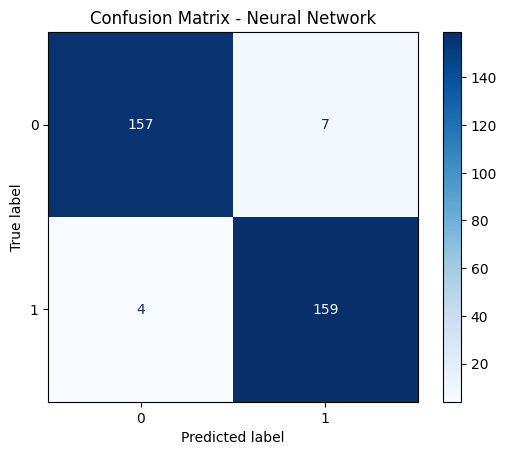

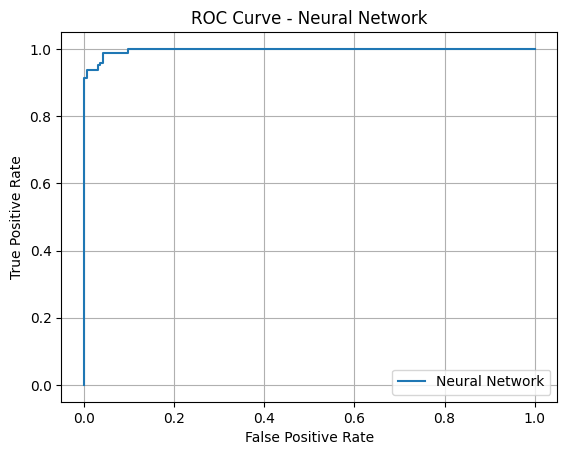

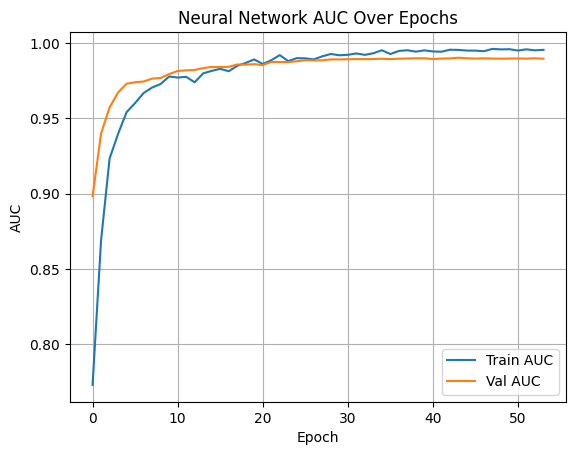

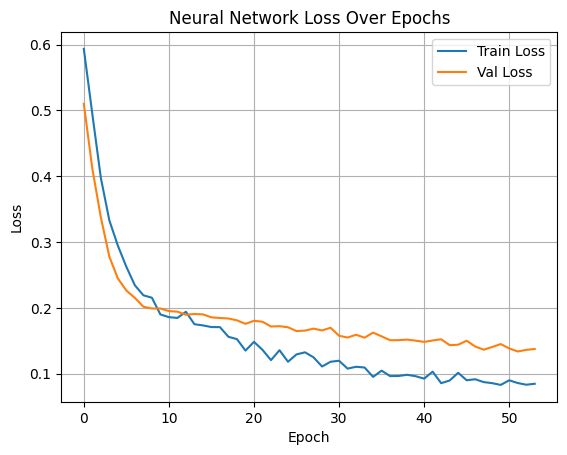

In [36]:
# === Neural Network ===

# Compute class weights manually
# neg, pos = np.bincount(y_train)
# class_weight = {0: 1.0, 1: neg / pos}

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_copy.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)
es = EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
history = model.fit(
    X_train_copy, y_train_copy,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    # class_weight=class_weight,
    callbacks=[es],
    verbose=2
)

model.save("balanced_churn_nn.keras")
# Evaluate NN
y_proba_nn = model.predict(X_test_copy).ravel()
y_pred_nn = (y_proba_nn > 0.5).astype(int)
print("=== Neural Network ===")
print(classification_report(y_test_copy, y_pred_nn))
print("NN ROC AUC:", roc_auc_score(y_test_copy, y_proba_nn))

# Confusion Matrix
cm_nn = confusion_matrix(y_test_copy, y_pred_nn)
disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm_nn, display_labels=[0, 1])
disp_nn.plot(cmap='Blues')
plt.title("Confusion Matrix - Neural Network")
plt.show()

# ROC Curve
fpr_nn, tpr_nn, _ = roc_curve(y_test_copy, y_proba_nn)
plt.plot(fpr_nn, tpr_nn, label='Neural Network')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Neural Network")
plt.grid(True)
plt.legend()
plt.show()

# AUC and Loss Curves
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('Neural Network AUC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Neural Network Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [44]:
# === Load model and scaler ===
model = load_model("/content/balanced_churn_nn.keras")
scaler = joblib.load("/content/balanced_churn_scaler.pkl")
# === Numeric columns used in training ===
numeric_cols = ['Age', 'Tenure', 'Balance', 'NumProducts', 'EstimatedSalary']

# === Extract first 10 samples from test set ===
X_test_sample = X_test_copy.tail(7).copy()

# === Scale numeric columns ===
X_test_sample[numeric_cols] = scaler.transform(X_test_sample[numeric_cols])

# === Predict churn probabilities and classes ===
probs = model.predict(X_test_sample).ravel()
preds = (probs > 0.5).astype(int)

# === Combine with original input for reference ===
results = X_test_sample.copy()
results['Churn_Probability'] = probs
results['Churn_Prediction'] = preds

# === Display results ===
pd.set_option('display.precision', 4)
print(results[['Churn_Probability', 'Churn_Prediction']])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
      Churn_Probability  Churn_Prediction
571              0.9988                 1
1334             1.0000                 1
1093             0.9993                 1
1440             0.9992                 1
567              0.9997                 1
1603             1.0000                 1
304              1.0000                 1
